# Web Scraping

In [3]:
"""
# @Author:  Zirui Zhou
# @Date:    2021/10/13 23:19:37
# @Contact: zirui.zhou19@student.xjtlu.edu.cn
""";

In [51]:
import queue
import threading


class QueueThread(threading.Thread):
    """A simple class to support tasks for queue in thread.

    Attributes:
        func: A function for the target task.
        queue: A queue.Queue object to acquire params for the function.
    """
    def __init__(self, func, queue):
        super().__init__()
        self.func = func
        self.queue = queue
        self.daemon = True

    def run(self):
        """Start function.
        """
        while True:
            # Exit the thread if there is no item in the queue.
            try:
                self.func(*self.queue.get_nowait())
            except queue.Empty:
                return
            self.queue.task_done()

In [52]:
import requests
import time


class CommonRequest:
    """A simple class to support basic requests.

    Attributes:
        retry_c: A list of HTTP status codes for retrying.
        retry_e: A tuple of Exceptions for retrying.
        retry_interval: A integer of the interval (second) between two retry requests.
    """
    retry_c = [
        requests.codes.too_many_requests,
    ]
    retry_e = (
        requests.exceptions.ConnectionError,
        # For Exceptions raised from `retry_c`.
        requests.exceptions.HTTPError,
        requests.exceptions.Timeout,
    )
    retry_interval = 1

    @classmethod
    def common_get(cls, url, params=None, timeout=5, logger=None):
        """A function for common get request.

        Args:
            url: A string of the request url.
            params: A dictionary of the params.
            timeout: A integer of the timeout (seconds).
            logger: A logger object for logging.

        Returns:
            A request.Response object of the target request.
        """
        return cls.retry(
            requests.get,
            logger=logger,
            url=url,
            params=params,
            timeout=timeout
        )

    @classmethod
    def retry(cls, func, logger=None, *args, **kwargs):
        """A helper function to retry requests when encountering errors and exceptions.

        Args:
            func: A function of the target request.
            logger: A logger object for logging errors and exceptions.
            *args: A list of params for the request function.
            **kwargs: A dictionary of params for the request function.

        Returns:
            A request.Response object of the target request.
        """
        while True:
            try:
                response = func(*args, **kwargs)
                if response.status_code in cls.retry_c:
                    response.raise_for_status()
                return response
            except cls.retry_e as e:
                if logger:
                    logger.info(e)
                time.sleep(cls.retry_interval)
                continue

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer


title_similarity_threshold = 0.5

def compare_title(query_title, resp_title, resp_subtitle):
    """Get the titles' text similarity by TFIDF.

    Args:
        query_title: A string of the original title.
        resp_title: A string of the target title.
        resp_subtitle: A string of the target subtitle.

    Returns:
         An integer of the text similarity of the titles.
    """

    # The original title is compared with target title and target title with subtitle.
    corpus = [query_title,
              resp_title,
              f"{resp_title} {resp_subtitle}"]

    # The stop_words is disabled due to the short length of the corpus.
    vect = TfidfVectorizer(min_df=1, stop_words=None)
    tfidf = vect.fit_transform(corpus)
    # The similarity is the maximum of the results.
    similarity = max((tfidf * tfidf.T).A[0, 1:])
    return similarity

In [54]:
import logging
import os
import sys
import time


def get_logger_handler(log_path=None, is_print=False, level=logging.DEBUG):
    """Generate the logger handlers.

    Args:
        log_path: A string of the log file path. None for no file output.
        is_print: A boolean of whether to print the log in console.
        level: A logging Level Object to set the logging level.

    Returns:
        A list of the logger's handlers.
    """
    handlers = list()
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    if is_print:
        handler = logging.StreamHandler(sys.stdout)
        handler.setLevel(level)
        handler.setFormatter(formatter)
        handlers.append(handler)

    if log_path:
        handler = logging.FileHandler(log_path, encoding="utf-8")
        handler.setLevel(level)
        handler.setFormatter(formatter)
        handlers.append(handler)

    return handlers

time_format = time.strftime('%Y-%m-%d %H-%M-%S', time.localtime())
log_path = "./log"
os.makedirs(log_path, exist_ok=True)

book_logger = logging.Logger("Book Scrape", level=logging.INFO)
book_logger.handlers = get_logger_handler(os.path.join(log_path, f"book {time_format}.log"))

net_logger = logging.Logger("Connection", level=logging.INFO)
net_logger.handlers = get_logger_handler(os.path.join(log_path, f"net {time_format}.log"))

In [55]:
import logging
import time


class DebugTimer:
    """A simple class to record runtime of some codes.

    Attributes:
        start_time: A double of the timer's start time.
        end_time: A double of the timer's end time.
        desc: A string of the description of target process.
        print_format: A string of format of print().
        logger: A logger to output the information.
    """
    start_time = 0
    end_time = 0
    desc = str()
    print_format = str()
    logger = logging.Logger("DebugTimer", level=logging.INFO)

    def __init__(self, desc="unknown process", logger=None):
        self.desc = desc
        self.print_format = "The duration of {} is: {} s.\n"
        self.logger.handlers = logger.handlers if logger else get_logger_handler(is_print=True)

    def __enter__(self):
        self.start()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end()

    def start(self):
        """Start the timer.
        """
        self.start_time = time.perf_counter()

    def end(self):
        """End the timer.
        """
        self.end_time = time.perf_counter()
        self.logger.info(self.print_format.format(self.desc, self.end_time - self.start_time))

In [7]:
from bs4 import BeautifulSoup
import json
import re
import requests


class ScrapeBookParser:
    """A simple class to parse the book information from a Book Scrape page.

    Attributes:
        book_soup: A BeautifulSoup Object of the Book Scrape page.
    """
    rating_str_to_num = {
        "one": 1,
        "two": 2,
        "three": 3,
        "four": 4,
        "five": 5,
    }

    def __init__(self, book_soup):
        self.book_soup = book_soup
        self.book_main_soup = self.book_soup.find("div", "product_main")
        self.book_table_soup = self.book_soup.find("table", "table table-striped")

    def get_title(self):
        return self.book_main_soup.h1.string

    def get_review_num(self):
        return int(self.book_table_soup.find("th", text="Number of reviews").find_next_sibling("td").string)

    def get_rating(self):
        return self.rating_str_to_num[self.book_main_soup.find("p", "star-rating")["class"][1].lower()]

    def get_description(self):
        desc_soup = self.book_soup.find("div", id="product_description")
        return desc_soup.find_next("p").string if desc_soup else None

    def get_price_excl_tax(self):
        return self.book_table_soup.find("th", text="Price (excl. tax)").find_next_sibling("td").string

    def get_price_excl_tax_num(self):
        price = self.get_price_excl_tax()
        price = get_number_pattern().search(price)
        return float(price.group()) if price else None

    def get_price_incl_tax(self):
        return self.book_table_soup.find("th", text="Price (incl. tax)").find_next_sibling("td").string

    def get_price_incl_tax_num(self):
        price = self.get_price_incl_tax()
        price = get_number_pattern().search(price)
        return float(price.group()) if price else None

    def get_product_type(self):
        return self.book_table_soup.find("th", text="Product Type").find_next_sibling("td").string

    def get_category(self):
        return self.book_soup.find("ul", "breadcrumb").find("li", "active").find_previous_sibling("li").a.string

    def get_availability(self):
        return self.book_table_soup.find("th", text="Availability").find_next_sibling("td").string

    def get_availability_num(self):
        available = self.get_availability()
        available = get_number_pattern().search(available)
        return int(available.group()) if available else None

class GoogleBookParser:
    """A simple class to parse the book information from Google Books API.

    Attributes:
        book_info: A dictionary of the book information from Google Books API.
    """
    def __init__(self, book_info):
        self.book_info = book_info

    def has_title(self):
        return "title" in self.book_info["volumeInfo"]

    def has_self_link(self):
        return "selfLink" in self.book_info

    def get_title(self):
        return self.book_info["volumeInfo"].get("title", "")

    def get_self_link(self):
        return self.book_info["selfLink"]

    def get_subtitle(self):
        return self.book_info["volumeInfo"].get("subtitle", "")

    def get_authors(self):
        return self.book_info["volumeInfo"].get("authors", [])

    def get_authors_str(self, sep=", "):
        return sep.join(self.get_authors())

    def get_average_rating(self):
        return self.book_info["volumeInfo"].get("averageRating", None)

    def get_rating_count(self):
        return self.book_info["volumeInfo"].get("ratingsCount", None)

    def get_page_count(self):
        return self.book_info["volumeInfo"].get("pageCount", None)

    def get_list_price(self):
        list_price = self.book_info.get("saleInfo", dict()).get("listPrice", None)
        return f"{list_price['amount']} {list_price['currencyCode']}" if list_price else None

    def get_retail_price(self):
        retail_price = self.book_info.get("saleInfo", dict()).get("retailPrice", None)
        return f"{retail_price['amount']} {retail_price['currencyCode']}" if retail_price else None

    def get_categories(self):
        return self.book_info["volumeInfo"].get("categories", [])

    def get_published_date(self):
        return self.book_info["volumeInfo"].get("publishedDate", None)

def get_book_item():
    return {
        "Title of Book": ScrapeBookParser.get_title,
        "Number of reviews": ScrapeBookParser.get_review_num,
        "Rating": ScrapeBookParser.get_rating,
        "Description": ScrapeBookParser.get_description,
        "Price": ScrapeBookParser.get_price_excl_tax_num,
        "Product Type": ScrapeBookParser.get_product_type,
        "Book category": ScrapeBookParser.get_category,
        "Availability": ScrapeBookParser.get_availability_num,
    }

def get_book_extra_item():
    return {
        "Google Author": GoogleBookParser.get_authors_str,
        "Google Page Count": GoogleBookParser.get_page_count,
        "Google Rating": GoogleBookParser.get_average_rating,
        "Google Rating Count": GoogleBookParser.get_rating_count,
        "Google Price": lambda p: GoogleBookParser.get_list_price(p) or GoogleBookParser.get_retail_price(p),
        "Google Category": lambda p: next(iter(GoogleBookParser.get_categories(p)), None),
        "Google Published Date": GoogleBookParser.get_published_date,
    }

def get_book_list_info():
    """Get the main book index information.

    Returns:
        A list which contains total number, first index in one page, last index in one page (i.e. number in one page).
    """
    response = CommonRequest.common_get("https://books.toscrape.com/index.html", logger=net_logger)
    soup = BeautifulSoup(response.content, "html.parser")
    return [int(item.string) for item in soup.find("form", "form-horizontal", method="get").find_all("strong")]

def get_book_url_list(page, url_list):
    """Get the book urls and put them into target queue for further scrapy.

    Args:
        page: An integer of the target page index.
        url_list: A list to put the urls into.
    """
    response = CommonRequest.common_get(f"https://books.toscrape.com/catalogue/page-{page}.html", logger=net_logger)
    soup = BeautifulSoup(response.content, "html.parser")
    urls = [item.a["href"] for item in soup.findAll("article", "product_pod")]
    url_list.extend(urls)

def get_book_info(url, book_info_list, pbar):
    """Get one book detailed information.

    Args:
        url: A string of the sub link of one book.
        book_info_list: A list of all the books' information.
        pbar: A tqdm.tqdm Object for the progress of book scrapy.
    """
    response = CommonRequest.common_get(f"https://books.toscrape.com/catalogue/{url}", logger=net_logger)
    soup = BeautifulSoup(response.content, "html.parser")
    book_parser = ScrapeBookParser(soup)

    book_info = [func(book_parser) for func in get_book_item().values()]

    # List append is thread-safe.
    book_info_list.append(book_info)
    pbar.update(1)

def get_book_extra_info(book_info, pbar, check_num=3, title_index=0):
    """Get one book extra information from multi-source.

    Args:
        book_info: A list of the book information from ToScrape.
        pbar: A tqdm.tqdm Object for the progress of book scrapy.
        check_num: A integer of the number of results to check the similarity.
        title_index: A integer of the index of the title position.

    Returns:
        A list of the extra information to concat with the basic one.
    """
    google_url = f'https://www.googleapis.com/books/v1/volumes'

    # Remove the possible Vol. info where # serves as stop mark which misleads the query.
    # For example: I Hate Fairyland, Vol. 1: Madly Ever After (I Hate Fairyland (Compilations) #1-5)
    query_title = re.sub(r"\(.*#.*\)", "", book_info[title_index])

    response = CommonRequest.common_get(
        google_url,
        {
            # Note that the query title will be quoted automatically.
            "q": query_title,
            "langRestrict": "en",
        },
        logger=net_logger
    )
    google_books = json.loads(response.content)
    google_books = google_books['items'] if 'items' in google_books.keys() else []
    book_extra_info = [None for _ in get_book_extra_item().values()]

    for google_book_info in google_books[:check_num]:
        book_parser = GoogleBookParser(google_book_info)

        # Sometimes, the query results is incomplete, which needs further request.
        if not book_parser.has_title() and book_parser.has_self_link():
            new_response = CommonRequest.common_get(book_parser.get_self_link(), logger=net_logger)
            google_book_info = json.loads(new_response.content)
            book_parser = GoogleBookParser(google_book_info)

        # Neglect the book which has no title information.
        if not book_parser.has_title():
            continue

        google_title = book_parser.get_title()
        google_subtitle = book_parser.get_subtitle()

        similarity = compare_title(query_title, google_title, google_subtitle)
        book_logger.info(
            f"\nRequest Title: {query_title}"
            f"\nResponse Title: {google_title}"
            f"\nResponse Subtitle: {google_subtitle}"
            f"\nSimilarity: {similarity}"
            f"\nRequest Url: {response.request.url}"
            f"\n"
        )

        # If the similarity exceeds the threshold, just judge that the two books are the same one.
        # Note that this may lead to some inaccuracy, if threshold is assigned to an unreasonable value, as it is a hyperparameter.
        # Refer to the book log for further fine-tune.
        if similarity > title_similarity_threshold:
            # Sometimes, the query results is incomplete, which needs further request.
            # However, this will double the request time, due to Google limit rate.
            # Thus, there do not apply self link recheck.
            book_extra_info = [func(book_parser) for func in get_book_extra_item().values()]
            break

    book_info.extend(book_extra_info)
    pbar.update(1)

def get_number_pattern():
    return re.compile(r"\d*\.\d+|\d+")

In [57]:
import pandas
import math
import tqdm


book_url_list = list()
book_info_list = list()
result_filepath = "./Zirui_Zhou+1927924.csv"

book_url_queue = queue.Queue()
scrape_book_queue = queue.Queue()
google_book_queue = queue.Queue()

with DebugTimer("Getting Book List Info"):
    total, _, step = get_book_list_info()
    print(f"The total book number is {total}.")

with DebugTimer("Getting Book Url List"):
    for idx in range(math.ceil(total/step)):
        book_url_queue.put((idx+1, book_url_list, ))
    for _ in range(10):
        QueueThread(get_book_url_list, book_url_queue).start()
    book_url_queue.join()

with DebugTimer("Getting Scrape Book Info"):
    scrape_pbar = tqdm.tqdm(range(total), position=0, leave=True)
    for url in book_url_list:
        scrape_book_queue.put((url, book_info_list, scrape_pbar,))
    for _ in range(20):
        QueueThread(get_book_info, scrape_book_queue).start()
    scrape_book_queue.join()

with DebugTimer("Writing CSV"):
    headers = list(get_book_item().keys())
    pandas.DataFrame(book_info_list, columns=headers).to_csv(result_filepath, sep='\t')

with DebugTimer("Getting Google Book Info"):
    google_pbar = tqdm.tqdm(range(total), position=0, leave=True)
    for book_info in book_info_list:
        google_book_queue.put((book_info, google_pbar, ))
    for _ in range(20):
        QueueThread(get_book_extra_info, google_book_queue).start()
    google_book_queue.join()

with DebugTimer("Writing CSV"):
    headers = list(get_book_item().keys()) + list(get_book_extra_item().keys())
    pandas.DataFrame(book_info_list, columns=headers).to_csv(result_filepath, sep='\t')

print("Done")

The total book number is 1000.
2022-10-20 00:31:27,542 - DebugTimer - INFO - The duration of Getting Book List Info is: 2.75594479998108 s.

2022-10-20 00:31:40,049 - DebugTimer - INFO - The duration of Getting Book Url List is: 12.50624550000066 s.



100%|██████████| 1000/1000 [01:59<00:00,  1.38it/s]

2022-10-20 00:33:39,460 - DebugTimer - INFO - The duration of Getting Scrape Book Info is: 119.41021170001477 s.

2022-10-20 00:33:39,499 - DebugTimer - INFO - The duration of Writing CSV is: 0.03800490003777668 s.



100%|██████████| 1000/1000 [09:24<00:00,  8.38s/it]

2022-10-20 00:43:03,740 - DebugTimer - INFO - The duration of Getting Google Book Info is: 564.2405178000336 s.

2022-10-20 00:43:03,782 - DebugTimer - INFO - The duration of Writing CSV is: 0.04096499999286607 s.

Done


# Data Analysis
This report tends to explore which factors affect the rating of books.

In [5]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas
import math
import re

result_filepath = "./Zirui_Zhou+1927924.csv"
book_info = pandas.read_csv(result_filepath, sep="\t")

Text(0.5, 0, 'Rating')

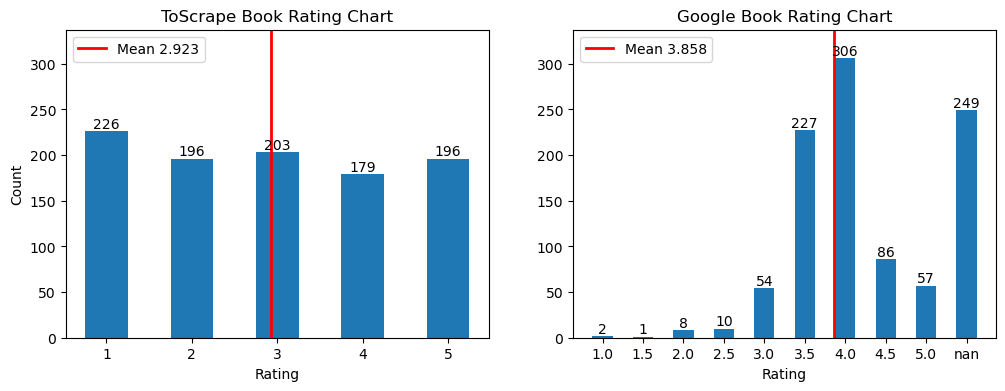

In [174]:
scrape_rating_info = book_info["Rating"].value_counts(dropna=False).sort_index()
google_rating_info = book_info["Google Rating"].value_counts(dropna=False).sort_index()


fig1, (ax, av) = plt.subplots(1, 2, sharey=True)
fig1.set_size_inches(12, 4)

bars = ax.bar([str(item) for item in scrape_rating_info.index], scrape_rating_info.values, width = 0.5, align="center")
ax.axvline((book_info["Rating"].mean() - 1), color='red', linewidth=2, label=f"Mean {'{0:0.3f}'.format(book_info['Rating'].mean())}")
_ = ax.bar_label(bars)
bottom, top = ax.get_ylim()
ax.set_ylim(top=top+100)
ax.legend(loc='upper left')

ax.set_title("ToScrape Book Rating Chart")
ax.set_xlabel("Rating")
ax.set_ylabel("Count")

bars = av.bar([str(item) for item in google_rating_info.index], google_rating_info.values, width = 0.5, align="center")
av.axvline((book_info["Google Rating"].mean() - 1) * 2, color='red', linewidth=2, label=f"Mean {'{0:0.3f}'.format(book_info['Google Rating'].mean())}")
_ = av.bar_label(bars)

av.yaxis.set_tick_params(labelleft=True)

av.legend(loc='upper left')

av.set_title("Google Book Rating Chart")
av.set_xlabel("Rating")

<AxesSubplot:xlabel='Google Rating', ylabel='Count'>

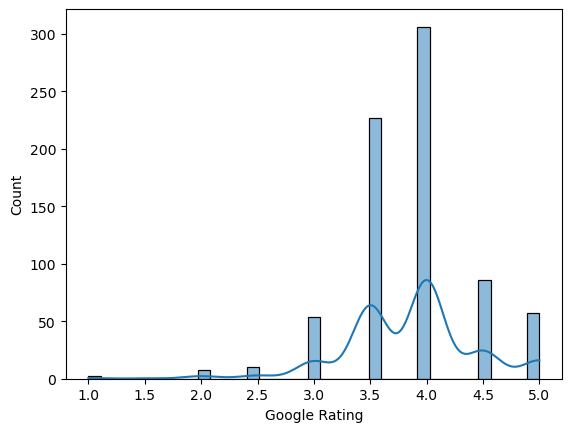

In [120]:
import seaborn as sns

sns.histplot(book_info["Google Rating"], kde=True)

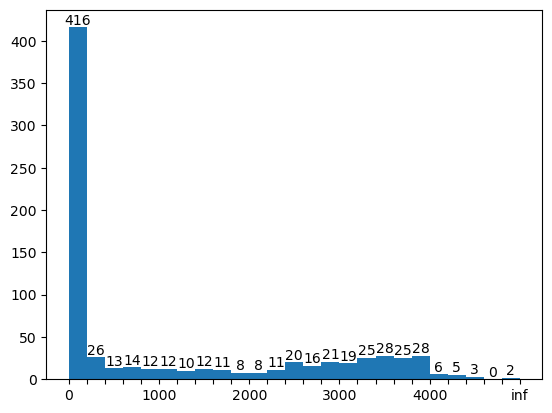

In [137]:
rating_count_info = book_info["Google Rating Count"].value_counts(bins=list(range(0, 5000, 200))+[math.inf]).sort_index()

_, ax2 = plt.subplots()
bars = ax2.bar([str(int(item.left)) for item in rating_count_info.index], rating_count_info.values, width = 1, align="edge")
_ = ax2.bar_label(bars)

ax2.set_xticks(list(ax2.get_xticks()) + [list(ax2.get_xticks())[-1] + 1])

plt.draw()

labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[-1] = "inf"


_ = ax2.set_xticklabels(labels)

for idx, label in enumerate(ax2.xaxis.get_ticklabels()[:-1]):
    label.set_visible(idx%5==0)


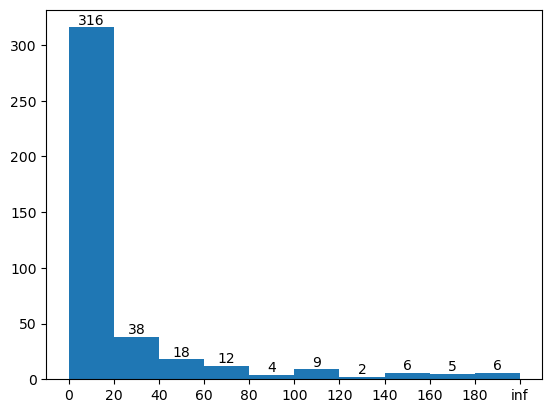

In [61]:
small_rating_count_info = book_info["Google Rating Count"].value_counts(bins=list(range(0, 200+20, 20))).sort_index()

_, ax3 = plt.subplots()
bars = ax3.bar([str(int(item.left)) for item in small_rating_count_info.index], small_rating_count_info.values, width = 1, align="edge")
_ = ax3.bar_label(bars)

ax3.set_xticks(list(ax3.get_xticks()) + [list(ax3.get_xticks())[-1] + 1])

plt.draw()

labels = [item.get_text() for item in ax3.get_xticklabels()]
labels[-1] = "inf"

_ = ax3.set_xticklabels(labels)

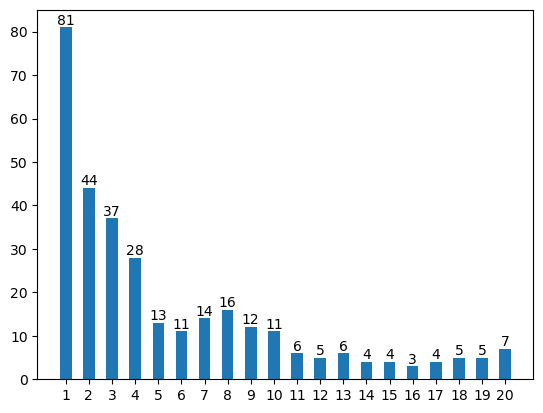

In [62]:
_, ax4 = plt.subplots()

smaller_rating_count_info = book_info["Google Rating Count"][book_info["Google Rating Count"].between(0, 20, inclusive="both")].value_counts().sort_index()
bars = ax4.bar([str(int(item)) for item in smaller_rating_count_info.index], smaller_rating_count_info.values, width = 0.5, align="center")
_ = ax4.bar_label(bars)

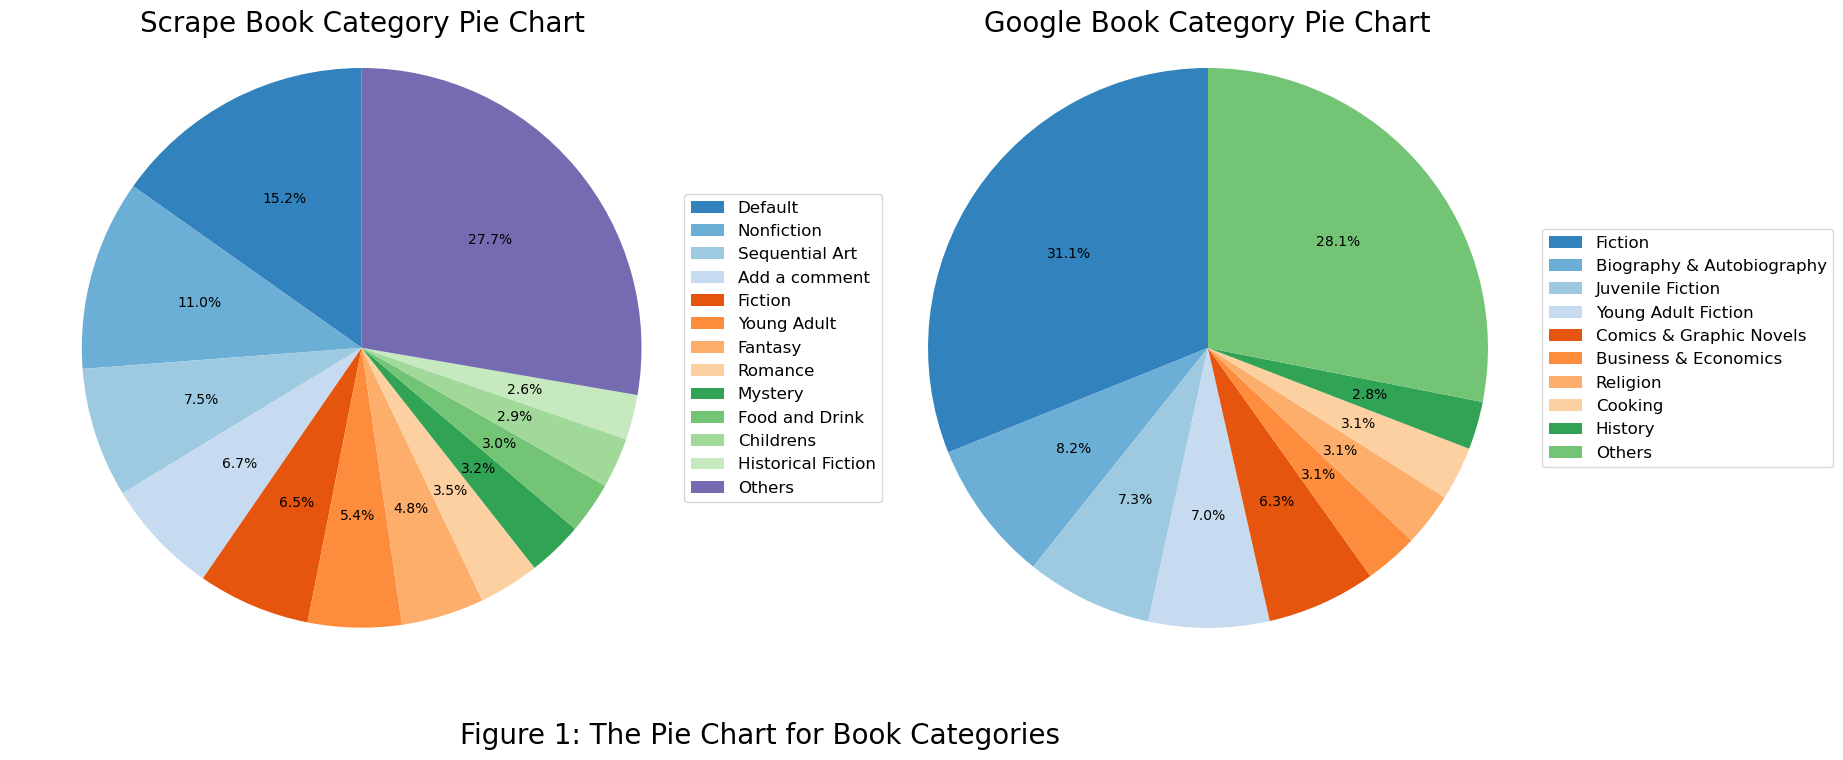

In [290]:
scrape_category_info = book_info["Book category"].value_counts()
google_category_info = book_info["Google Category"].value_counts()

scrape_category_info = pandas.concat([
    scrape_category_info[scrape_category_info.ge(20)],
    pandas.Series(scrape_category_info[scrape_category_info.between(0, 20, inclusive="both")].sum(), ["Others"])
])

google_category_info = pandas.concat([
    google_category_info[google_category_info.ge(20)],
    pandas.Series(google_category_info[google_category_info.between(0, 20, inclusive="both")].sum(), ["Others"])
])

import numpy as np
cmap = plt.get_cmap("tab20c")
inner_colors = list(cmap.colors)

fig5, (ax5, av5) = plt.subplots(1, 2)
fig5.set_size_inches(20, 8)

ax5.pie(scrape_category_info.values, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=inner_colors)
_ = ax5.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax5.set_title("Scrape Book Category Pie Chart", fontsize=20)
ax5.legend(labels=scrape_category_info.index, bbox_to_anchor=(1.25,0.5), loc="center right", fontsize=12
          )

av5.pie(google_category_info.values, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=inner_colors)
_ = av5.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# av5.legend(labels=google_category_info.index)
av5.legend(labels=google_category_info.index, bbox_to_anchor=(1.4,0.5), loc="center right", fontsize=12
           )
av5.set_title("Google Book Category Pie Chart", fontsize=20)
_ = fig5.text(s="Figure 1: The Pie Chart for Book Categories", x =0.5, y= 0.00, ha="center", fontsize=20)

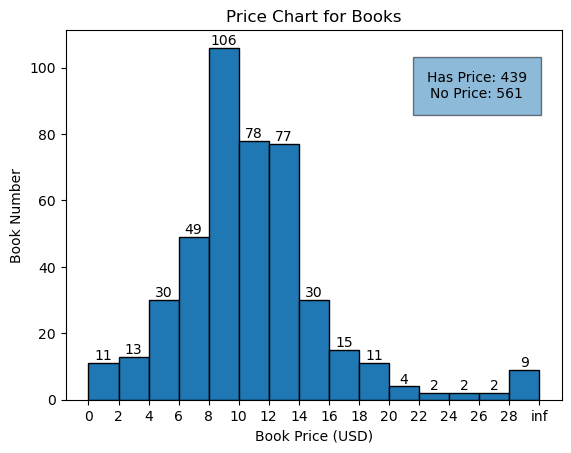

In [64]:
price_info = book_info["Google Price"].dropna().apply(lambda x: float(get_number_pattern().findall(x)[0]))
price_info = price_info.value_counts(bins=list(range(0, 30, 2))+[math.inf]).sort_index()

fig6, ax6 = plt.subplots()

bars = ax6.bar([str(int(item.left)) for item in price_info.index], price_info.values, width = 1, align="edge", linewidth=1, edgecolor="black")
_ = ax6.bar_label(bars)
# ax6.set_xticks(list(ax6.get_xticks()) + [list(ax6.get_xticks())[-1] + 1])


ax6.set_xticks(list(ax6.get_xticks()) + [list(ax6.get_xticks())[-1] + 1])

ax6.set_title("Price Chart for Books")
ax6.set_xlabel("Book Price (USD)")
ax6.set_ylabel("Book Number")

ax6.  text(
    0.8,
    0.85,
    (f"Has Price: {book_info['Google Price'].dropna().count()}\n"
     f"No Price: {book_info['Google Price'].isna().sum()}"),
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax.transAxes,
    bbox={'facecolor': 'tab:blue', 'alpha': 0.5, 'pad': 10})

plt.draw()

labels = [item.get_text() for item in ax6.get_xticklabels()]
labels[-1] = "inf"

_ = ax6.set_xticklabels(labels)
_ = fig6.text(s="Figure 1: The Price Chart for Books", x =0.5, y= -0.05, ha="center")

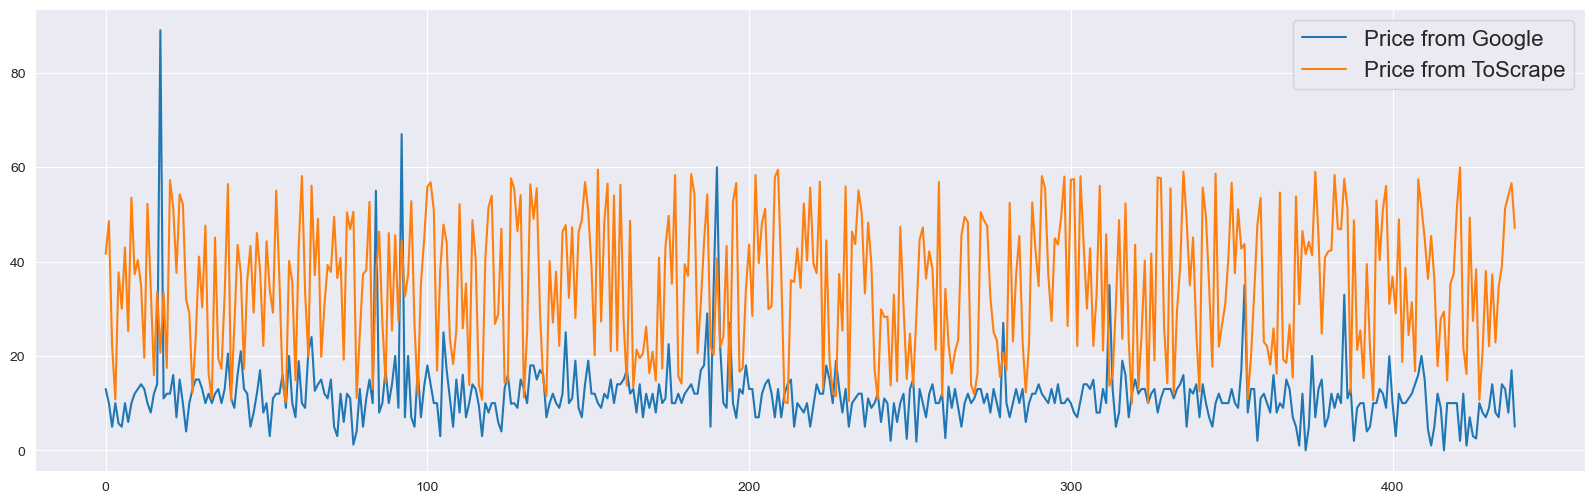

In [11]:
google_price_info = book_info["Google Price"].dropna().apply(lambda x: float(get_number_pattern().findall(x)[0])).sort_index().reset_index(drop=True)

scrape_price_info = book_info[book_info["Google Price"].notna()]["Price"].sort_index().reset_index(drop=True)


fig7, ax7 = plt.subplots()

fig7.set_size_inches(20, 6)
ax7.plot(google_price_info.index, google_price_info.values, label="Price from Google")
ax7.plot(scrape_price_info.index, scrape_price_info.values, label="Price from ToScrape")
# ax7.bar(google_price_info.index, google_price_info.values, label="Price from Google")
# ax7.bar(scrape_price_info.index, scrape_price_info.values, label="Price from ToScrape")
ax7.legend(fontsize=16)